# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---

1. Prepare
    - 1.1. Libraries Initialization
    - 1.2. Helper Visualization Functions
    - 1.3. Color Correction Functions
2. Model Definition
3. Data Processing
4. Train 1 - Initial set with normalization

> Note: Most of the code below requires refactoring and better representation wrapped into classes.

---

# 1. Prepare

---

## 1.1. Libraries Initialization

Here we load all required for the future images processing and model training libraries:
- **random, math** - mathematical libraries from a standard python suit to handle all required math
- **numpy** - great scientific library to process data arrays
- **pickle** - library to serialize and deserialize data
http://www.numpy.org
- **matplotlib.pyplot** - plotting library
https://matplotlib.org
- **pandas** - another great library to process data
https://pandas.pydata.org
- **cv2** - image processing library
http://opencv.org
- **tensorflow** - machine learning framework
https://www.tensorflow.org
- **sklearn** - scientific library for data processing and many other things
http://scikit-learn.org

In [1]:
import random
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

---

## 1.2. Helper Visualization Functions

- **display_distribution, show_learning_curve** - display different plots
- **normalize_for_preview, insert_subimage, display_image_set, display_image_batch, display_images, examples_test** - functions to display batch of images
- **display_tensor, visualize, draw_one_hot** - functions to display different tensors

In [154]:
%matplotlib inline

def display_distribution(elements, labels, height = 10, titles = None):
    cool_colors = ['#e74c3c', '#2980b9', '#2ecc71', '#f1c40f']
    plt.figure(figsize = (20, height))

    if titles is not None:
        type_num = len(titles)
        bars = []
        widths = []
        np_elements = np.empty([len(titles), len(labels)], dtype=np.uint32)
        
        for element in elements:
            np.append(np_elements, element)
        
        for i in range(type_num):
            type_elements = elements[i]
            examples_per_class = np.bincount(type_elements.astype(np.int64))
            num_classes = len(examples_per_class)
            x = np.arange(num_classes)
            bar = plt.bar(x + i / (type_num + 1), examples_per_class, 1 / (type_num + 1), color=cool_colors[i])
            bars.append(bar)
            
        plt.legend(tuple(bars), tuple(titles))
    else:
        examples_per_class = np.bincount(elements.astype(np.int64))
        num_classes = len(examples_per_class)
        x = np.arange(num_classes)
        plt.bar(x, examples_per_class, 0.8, color=cool_colors[0], label='Inputs per class')
        
    plt.xlabel('Class number')
    plt.xticks(x, labels, rotation='vertical')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show()  
    
def show_learning_curve(epochs, accuracy, loss):
    colors = ['#e74c3c', '#2980b9']
    loss_train, loss_valid = loss
    accuracy_train, accuracy_valid = accuracy

    plt.figure(figsize=(10, 10))
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.scatter(np.arange(epochs), loss_train, color=colors[0])
    ax1.scatter(np.arange(epochs), loss_valid, color=colors[1])
    ax1.plot(np.arange(epochs), loss_train, color=colors[0])
    ax1.plot(np.arange(epochs), loss_valid, color=colors[1])
    ax1.set_title('Loss')
    ax1.legend(['training', 'validation'], loc='best')
    
    ax2.scatter(np.arange(epochs), accuracy_train, color=colors[0])
    ax2.scatter(np.arange(epochs), accuracy_valid, color=colors[1])
    ax2.plot(np.arange(epochs), accuracy_train, color=colors[0])
    ax2.plot(np.arange(epochs), accuracy_valid, color=colors[1])
    ax2.set_title('Accuracy')
    ax2.legend(['training', 'validation'], loc='best')
    
def normalize_for_preview(images):
    normalized_images = np.empty([0, images.shape[1], images.shape[2], images.shape[3]], dtype = np.uint8)

    for img in images:
        new_image = np.empty(img.shape, dtype = np.uint8)

        for channel_idx in range(img.shape[-1]):
            channel_min = img[..., channel_idx].min()
            channel_max = img[..., channel_idx].max()

            if channel_min < 0 or channel_max > 255:
                new_image[:,:,channel_idx] = 255.0 * (img[:,:,channel_idx] - channel_min) / (channel_max - channel_min)
            else:
                new_image[:,:,channel_idx] = img[:,:,channel_idx]
                
        normalized_images = np.append(normalized_images, new_image[None,:], axis=0)

    return normalized_images

def insert_subimage(image, sub_image, y, x): 
    h, w, _ = sub_image.shape
    image[y:y + h, x:x + w, :] = sub_image 
    return image

def display_image_set(training_set, label_set):
    num_sample = 10
    img_height = 30
    _, height, width, channel = training_set.shape
    result_image_shape = (classes_in_train * height, (num_sample + 2 + 22) * height, channel)
    results_image = 255 * np.ones(shape=result_image_shape, dtype=np.uint8)

    for c in range(classes_in_train):
        idx = list(np.where(c == label_set)[0])

        if len(idx) > 0:
            mean_image = np.average(training_set[idx], axis = 0)
            insert_subimage(results_image, mean_image, c * height, width)
            
            for n in range(num_sample):
                sample_image = training_set[np.random.choice(idx)]
                insert_subimage(results_image, sample_image, c * height, (2 + n) * width + 20)

        text = '%02d. %-6s'%(c, classes[c])
        text_pos = ((2 + num_sample) * width + 30, int((c + 0.7) * height))
        text_col = (0, 0, 0)
        cv2.putText(results_image, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_col, 1)

    cv2.imwrite('./train_data_initial_summary.jpg', cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.rcParams["figure.figsize"] = (25, 25)
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()
    
def display_image_batch(X, y, batch=6, custom_titles=None):
    if custom_titles is None:
        X, y = shuffle(X, y)
        titles_train = list(map(lambda x: titles[x], y))
        display_images(X[:6], 6, titles=titles_train, height=6)
    else:
        display_images(X[:6], 6, titles=custom_titles, height=6)
        
def display_images(images, n_cols, titles = None, height = 5):
    dataset = normalize_for_preview(images)
    dataset = dataset.astype(np.uint8)
    elements_num = len(dataset)
    n_rows = math.ceil(elements_num / n_cols) + 1
    
    plt.figure(figsize = (20, height))
    
    sample = images[np.random.randint(0, len(images))]
    r_min = sample[..., 0].min()
    r_max = sample[..., 0].max()
    
    if sample.shape[-1] > 1:
        g_min = sample[..., 1].min()
        g_max = sample[..., 1].max()
        b_min = sample[..., 2].min()
        b_max = sample[..., 2].max()
        plt.suptitle("Slice element {}; R {} to {}, G {} to {}, B {} to {}".format(sample.shape, r_min, r_max, g_min, g_max, b_min, b_max))
    else:
        plt.suptitle("Slice element {}; R {} to {}".format(sample.shape, r_min, r_max))
        
    for i in range(0, elements_num):
        element = dataset[i]
        depth = element.shape[-1]
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.axis('off')
        
        if titles is None:
            plt.title('Element ' + str(i))
        else:
            plt.title(titles[i])

        if depth == 1:
            plt.imshow(element.squeeze(), cmap="gray") 
        else:
            plt.imshow(element)
            
    plt.show()
            
def show_examples_test(preds, X_data, validation_set, all_classes, y_data=None, height=12):
    X_valid_set, y_valid_set = validation_set
    images = np.empty([0, 32, 32, 3], dtype = np.uint8)
    titles = []

    for i, image in enumerate(X_data):
        images = np.concatenate((images, image[None,:]), axis=0)
        
        if y_data is None:
            titles.append("Image" + str(i))
        else:
            titles.append(all_classes[y_data[i]])

        for j in range(3):
            guess = preds[1][i][j]
            index = np.argwhere(y_valid_set == guess)[0][0]
            images = np.concatenate((images, X_valid_set[index][None,:]), axis=0)
            titles.append('{} ({:.0f}%)'.format(all_classes[guess], preds[0][i][j]))

    display_images(images, 4, titles=titles, height=height)
    
def display_tensor(tensor, n_cols = 6, title = "Draw tensor", height = 8):
    filters = tensor.shape[3]
    n_rows = math.ceil(filters / n_cols) + 1
    
    plt.figure(figsize = (20, height))
    plt.suptitle(title + ', Shape ' + str(tensor.shape))
    
    for i in range(filters):
        element = tensor[0, :, :, i]
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.axis('off')
        plt.title('Iteration ' + str(i))
        plt.imshow(element, interpolation = "nearest", cmap = "gray")
        
def visualize(x, title):
    res = sess.run(x)
    display_tensor(res, 6, title = title)
    
def draw_one_hot(vals, classes):
    titles = list(zip(range(len(classes)), list(map(lambda x: x, classes.values))))
    titles = list(map(lambda x: '{}. {}'.format(x[0], x[1]), titles))
    vals = res[0].astype(np.int)
    examples_per_class = np.bincount(vals)
    x_val = np.arange(examples_per_class[0] + 1)
    plt.figure(figsize = (20, 2))
    plt.bar(x_val, vals, 0.8, color='#dd1c77', label='Inputs per class')
    plt.xlabel('Class')
    plt.xticks(x_val, titles, rotation='vertical')
    plt.ylabel('One-hot')
    plt.title('Distribution of One-hot')

    plt.show()  

---

## 1.3. Color Correction Functions

- **lum_clahe** - CLAHE LAB histogram equalization
- **lum_eqhist** - L from LAB histogram equalization
- **rgb_eqhist** - RGB channels histogram equalization
- **add_gray** - function to add a grayscale as a 4-th channel
- **normalize_mean** - Per channel mean normalization for 3-channels images

In [155]:
def lum_clahe(img):
    #X[i, :, :, 1] = clahe.apply(X[i,:,:,1])
    lab = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    lab = cv2.merge((l2, a, b))
    
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
def lum_eqhist(img):
    lab = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l2 = cv2.equalizeHist(l)
    lab = cv2.merge((l2, a, b))
    
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def rgb_eqhist(img):
    new_img = np.empty(img.shape, dtype = np.uint8)
    new_img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    new_img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    new_img[:,:,2] = cv2.equalizeHist(img[:,:,2])
    
    return new_img
    
def add_gray(images):
    shape = images.shape
    images = np.copy(np.concatenate((images, np.zeros((shape[0], shape[1], shape[2], 1))), axis=3))

    for i in range(len(images)):
        img = images[i].astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        cv2.normalize(gray, gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        r, g, b, a = cv2.split(img)
        images[i] = cv2.merge((r, g, b, gray))

    return images

def to_normalized_gray(images):
    for i in range(len(images)):
        img = images[i].astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        cv2.normalize(gray, gray, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images[i] = cv2.merge((gray, gray, gray))

    return images

def normalize_mean(x):
    r = x[:,:,:,0]   
    g = x[:,:,:,1]
    b = x[:,:,:,2]
    
    r_norm = (r - r.mean()) / r.std()
    g_norm = (g - g.mean()) / g.std()
    b_norm = (b - b.mean()) / b.std()
    
    return np.stack((r_norm, g_norm, b_norm), axis=3)

In [156]:
def random_brightness(image, ratio):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness > 255] = 255
    brightness[brightness < 0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def random_rotation(image, angle):
    if angle == 0:
        return image
    
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)

def random_translation(image, translation):
    if translation == 0:
        return 0
    
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)

def random_shear(image, shear):
    if shear == 0:
        return image
    
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)

def augment(image, brightness, angle, translation, shear):
    image = random_brightness(image, brightness)
    image = random_rotation(image, angle)
    image = random_translation(image, translation)
    return random_shear(image, shear)

def cross_flip(classes_to_flip, X, y):
    X_flipped = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=np.float32)
    y_flipped = np.empty([0], dtype=np.uint32)

    for c in classes_to_flip[:, 0]:
        flip_class = classes_to_flip[classes_to_flip[:, 0] == c][0][1]
        flipped = X[y == flip_class][:, :, ::-1, :]
        X_flipped = np.append(X_flipped, flipped, axis=0)
        y_flipped = np.append(y_flipped, np.full((X_flipped.shape[0] - y_flipped.shape[0]), c))
        
    return (X_flipped, y_flipped)

def flip_images(classes_to_flip, X, y, flip_type):
    X_flipped = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=np.float32)
    y_flipped = np.empty([0], dtype=np.uint32)
    
    for c in classes_to_flip:
        if flip_type == 'horizontal':
            flipped = X[y == c][:, :, ::-1, :]
        elif flip_type == 'vertical':
            flipped = X[y == c][:, ::-1, :, :]
        elif flip_type == 'both':
            flipped = X[y == c][:, ::-1, ::-1, :]
        else:
            raise 'Invalid flip type'
            
        X_flipped = np.append(X_flipped, flipped, axis = 0)
        y_flipped = np.append(y_flipped, np.full((X_flipped.shape[0] - y_flipped.shape[0]), c))
        
    return (X_flipped, y_flipped)

---

# 2. Model Definition

---

- **conv** - convolution layer
- **fcl** - fully connected layer
- **train_net** - run training
- **loss_accuracy** - get loss and accuracy
- **epoch_ops** - this function contains epoch operations
- **write_stats** - write epoch stats to Tensorboard
- **write_layer** - function to write image set to Tensorboard. Use for drawing activations or weights
- **new_session** - create a new session
- **restore_session** - restore a session
- **test_session** - use to get a test accuracy and loss on a saved network
- **calculate** - use to start training

In [157]:
def conv(x, k_size, depth, mu, sigma, name):
    prev_shape = x.get_shape()
    prev_depth = prev_shape[-1]
    
    rand_weights = tf.truncated_normal(shape = [k_size, k_size, int(prev_depth), depth], mean=mu, stddev=sigma)
    weights = tf.Variable(rand_weights, dtype=tf.float32, name='W_' + name)
    bias = tf.Variable(tf.truncated_normal([depth]), name='b_' + name)
    conv = tf.nn.conv2d(x, weights, strides = [1, 1, 1, 1], padding = 'VALID')
    return tf.nn.bias_add(conv, bias)

def fcl(x, out, mu, sigma, name, isLogits=False):
    weights = tf.Variable(tf.truncated_normal(shape = [x.get_shape()[1].value, out], mean=mu, stddev=sigma), name='W_' + name)
    bias = tf.Variable(tf.truncated_normal([out]), name='b_' + name)
    
    if isLogits == False:
        return tf.add(tf.matmul(x, weights), bias)
    else:
        return tf.add(tf.matmul(x, weights), bias, name='op_logits')
    
def train_net(sess, variables, X_data, y_data, probe, t_training, t_summary):
    BATCH_SIZE = 128
    num_examples = len(X_data)
    
    x, y, keep_prob, v_global_step = variables
    
    global_step_val = tf.train.global_step(sess, v_global_step)
    log_dir = "./logs/" + str(global_step_val)
    summary_writer = tf.summary.FileWriter(log_dir, graph=sess.graph)
                
    print("Start training global_step: %s" % global_step_val)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        feed = {x: batch_x, y: batch_y, keep_prob: probe}
        _, summary = sess.run([t_training, t_summary], feed_dict=feed)
        summary_writer.add_summary(summary, i * BATCH_SIZE + offset)
                    
    summary_writer.close()
    
def loss_accuracy(sess, v_x, v_y, v_keep_prob, X_data, y_data, title, t_loss, t_accuracy):
    BATCH_SIZE = 128
    total_loss = 0
    total_accuracy = 0
    num_examples = len(X_data)

    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        feed = {v_x: batch_x, v_y: batch_y, v_keep_prob: 1.0}
        batch_loss, batch_accuracy = sess.run([t_loss, t_accuracy], feed_dict=feed)
        total_loss += (batch_loss * len(batch_x))
        total_accuracy += (batch_accuracy * len(batch_x))

    loss, accuracy = total_loss / num_examples, total_accuracy / num_examples
    print("{} Loss {:.3f}; Accuracy {:.3f}".format(title, loss, accuracy))
    
    return loss, accuracy
    
def epoch_ops(data_train, data_valid, probe, variables, tensors, sess, saver):
    X_train, y_train = data_train
    X_valid, y_valid = data_valid
    X_train, y_train = shuffle(X_train, y_train)
    X_valid, y_valid = shuffle(X_valid, y_valid)
    
    x, y, keep_prob, v_global_step = variables
    t_training, t_summary, t_loss, t_accuracy = tensors

    train_net(sess, variables, X_train, y_train, probe, t_training, t_summary)
    train_loss, train_accuracy = loss_accuracy(sess, x, y, keep_prob, X_train, y_train, 'Training', t_loss, t_accuracy)
    valid_loss, valid_accuracy = loss_accuracy(sess, x, y, keep_prob, X_valid, y_valid, 'Validation', t_loss, t_accuracy)

    global_step_val = tf.train.global_step(sess, v_global_step)
    stats = ["accuracy_train", "accuracy_valid", "loss_train", "loss_valid"]
    tags = ["total_accuracy", "total_accuracy", "total_loss", "total_loss"]
    values = [train_accuracy, valid_accuracy, train_loss, valid_loss]
    write_stats(stats, tags, values, sess.graph, global_step_val)
                
    saver.save(sess, "./model/p2_net", global_step=v_global_step, write_meta_graph=True)
    print("Model saved to", tf.train.latest_checkpoint('./model'))
    print()
    
def write_stats(stats, tags, values, graph, global_step_val):
    for title, tag, value in zip(stats, tags, values):
        writer = tf.summary.FileWriter("./logs/" + title, graph=graph)
        summary = tf.Summary(value=[
            tf.Summary.Value(tag=tag, simple_value=value), 
        ])
        writer.add_summary(summary, global_step_val)
        writer.flush()
        writer.close()
        
def write_layer(layer, title):
    margin = 10
    shape = layer.get_shape().as_list()[1:]
    iy = shape[0]
    ix = shape[1]
    depth = shape[2]
    
    cy = math.ceil(math.sqrt(depth))
    cx = cy
        
    V = tf.slice(layer, (0, 0, 0, 0), (1, -1, -1, -1), name='slice_' + title)
    V = tf.reshape(V, (iy, ix, depth))
    iy += margin
    ix += margin
    V = tf.image.resize_image_with_crop_or_pad(V, iy, ix)
    
    a_as_vector = tf.reshape(V, [-1])
    zero_padding = tf.zeros([iy * ix * cy * cx] - tf.shape(a_as_vector), dtype=V.dtype)
    V = tf.concat(0, [a_as_vector, zero_padding])
    V = tf.reshape(V, (iy, ix, cy, cx)) 
    
    V = tf.transpose(V, (2, 0, 3, 1)) # cy, iy, cx, ix
    V = tf.reshape(V, (-1, cy * iy, cx * ix, 1)) # Bring into shape expected by image_summary
    tf.summary.image(title, V)
            
def new_session(path, data_train, data_valid, epochs, probe):
    print("New session")
    print()
    
    mu = 0
    sigma = 0.1
    BATCH_SIZE = 128
    rate = 0.001
    
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(1)
        
        x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='p_x')
        y = tf.placeholder(tf.int32, (None), name='p_y')
        keep_prob = tf.placeholder(tf.float32, name='p_probe')
        v_global_step = tf.Variable(0, dtype = tf.int32, trainable=False, name='global_step')

        layer1 = conv(x, 5, 16, mu, sigma, 'cl1') # Input = 32x32x3. Output = 28x28x16.
        write_layer(layer1, "cl-1_weights")
        layer1 = tf.nn.tanh(layer1)
        write_layer(layer1, "cl-1_activation")
        layer1 = tf.nn.max_pool(layer1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME') # Output = 14x14x16.

        layer2 = conv(layer1, 5, 32, mu, sigma, 'cl2') # Output = 14x14x32.
        layer2 = tf.nn.tanh(layer2)
        layer2 = tf.nn.max_pool(layer2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME') # Output = 5x5x32. 

        shape = layer2.get_shape()[1:]
        flat = tf.reshape(layer2, [-1, int(shape[0] * shape[1] * shape[2])]) # Output = 800
        flat = tf.nn.tanh(flat)

        layer_fcl_1 = fcl(flat, 560, mu, sigma, 'fcl1') # Output = 560; 30% from 800
        layer_fcl_1 = tf.nn.tanh(layer_fcl_1)

        layer_fcl_2 = fcl(layer_fcl_1, 336, mu, sigma, 'fcl2') # Output = 84; 40% from 560
        layer_fcl_2 = tf.nn.tanh(layer_fcl_2)
        layer_fcl_2 = tf.nn.dropout(layer_fcl_2, keep_prob)

        t_logits = fcl(layer_fcl_2, classes_in_train, mu, sigma, 'fcl3', isLogits=True) # Output = n_classes.

        t_one_hot = tf.one_hot(y, classes_in_train, name='op_one_hot')
        t_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t_one_hot, logits=t_logits, name='op_entropy')
        t_loss = tf.reduce_sum(t_entropy, name='op_loss')

        optimizer = tf.train.AdamOptimizer(learning_rate=rate)
        t_training = optimizer.minimize(t_loss, global_step=v_global_step, name='op_training')

        t_correct = tf.equal(tf.argmax(t_logits, 1), tf.argmax(t_one_hot, 1), name='op_correct')
        t_accuracy = tf.reduce_mean(tf.cast(t_correct, tf.float32), name='op_accuracy')
        
        tf.summary.scalar("loss", t_loss)
        tf.summary.scalar("accuracy", t_accuracy)
        t_summary = tf.summary.merge_all()

        with tf.Session(graph=graph) as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()

            variables = [x, y, keep_prob, v_global_step]
            tensors = [t_training, t_summary, t_loss, t_accuracy]
            
            for i in range(epochs):
                epoch_ops(data_train, data_valid, probe, variables, tensors, sess, saver)

def restore_session(path, data_train, data_valid, epochs, probe):
    print("Restore session", path)
    print()
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(path + '.meta')
        saver.restore(sess, path)
        with sess.graph.as_default():
            graph = sess.graph
            tf.set_random_seed(1)
            
            x = graph.get_tensor_by_name("p_x:0")
            y = graph.get_tensor_by_name("p_y:0")
            keep_prob = graph.get_tensor_by_name('p_probe:0')
            v_global_step = graph.get_tensor_by_name('global_step:0')
            
            t_training = graph.get_tensor_by_name('op_training:0')
            t_loss = graph.get_tensor_by_name('op_loss:0')
            t_accuracy = graph.get_tensor_by_name('op_accuracy:0')
            t_logits = graph.get_tensor_by_name('op_logits:0')
            t_one_hot = graph.get_tensor_by_name('op_one_hot:0')
            
            t_summary = graph.get_tensor_by_name('Merge/MergeSummary:0')
            
            variables = [x, y, keep_prob, v_global_step]
            tensors = [t_training, t_summary, t_loss, t_accuracy]
            
            for i in range(epochs):
                epoch_ops(data_train, data_valid, probe, variables, tensors, sess, saver)
                
def test_session(data_test):
    path = tf.train.latest_checkpoint('./model')
    print("Start test session", path)
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(path + '.meta')
        saver.restore(sess, path)
        with sess.graph.as_default():
            graph = sess.graph
            tf.set_random_seed(1)
            
            x = graph.get_tensor_by_name("p_x:0")
            y = graph.get_tensor_by_name("p_y:0")
            keep_prob = graph.get_tensor_by_name('p_probe:0')
            v_global_step = graph.get_tensor_by_name('global_step:0')
            
            t_loss = graph.get_tensor_by_name('op_loss:0')
            t_accuracy = graph.get_tensor_by_name('op_accuracy:0')

            X_test, y_test = data_test
            test_loss, test_accuracy = loss_accuracy(sess, x, y, keep_prob, X_test, y_test, 'Testing', t_loss, t_accuracy)
            
            global_step_val = tf.train.global_step(sess, v_global_step)
            stats = ["accuracy_test", "loss_test"]
            tags = ["total_accuracy", "total_loss"]
            values = [test_accuracy, test_loss]
            write_stats(stats, tags, values, sess.graph, global_step_val)
            
def examples_session(examples, validation_set, image_classes, labels=None, height=12):
    X_valid_file, y_valid_file = validation_set
    
    path = tf.train.latest_checkpoint('./model')
    print("Start examples session", path)

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(path + '.meta')
        saver.restore(sess, path)
        with sess.graph.as_default():
            graph = sess.graph
            tf.set_random_seed(1)

            x = graph.get_tensor_by_name("p_x:0")
            y = graph.get_tensor_by_name("p_y:0")
            keep_prob = graph.get_tensor_by_name('p_probe:0')

            t_logits = graph.get_tensor_by_name('op_logits:0')
            t_top_k = tf.nn.top_k(t_logits, k=5)
            predictions = sess.run(t_top_k, feed_dict={x: normalize_mean(examples), keep_prob: 1.0})

            show_examples_test(predictions, examples, validation_set, image_classes, y_data=labels, height=height)
    
def calculate(data_train, data_valid, epochs, probe):
    print("tensorboard --logdir=./logs\nhttp://0.0.0.0:6006/")
    path = tf.train.latest_checkpoint('./model')
    
    if path is None:
        new_session(path, data_train, data_valid, epochs, probe)     
    else:
        restore_session(path, data_train, data_valid, epochs, probe)

---

# 3. Data Processing

---

Here we load training, validation and test sets. Cells below will show an overview of incoming data.

In [5]:
training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'
labels_file = './traffic-signs-data/signnames.csv'

with open(training_file, mode = 'rb') as f:
    train = pickle.load(f)
    
with open(validation_file, mode = 'rb') as f:
    valid = pickle.load(f)
    
with open(testing_file, mode = 'rb') as f:
    test = pickle.load(f)

X_train_file, y_train_file = train['features'].astype(np.uint8), train['labels'].astype(np.int32)
X_valid_file, y_valid_file = valid['features'].astype(np.uint8), valid['labels'].astype(np.int32)
X_test_file, y_test_file = test['features'].astype(np.uint8), test['labels'].astype(np.int32)
classes = pd.read_csv('./traffic-signs-data/signnames.csv')['SignName'].values
classes_in_train = len(np.unique(y_train_file)) # How many unique classes/labels there are in the dataset.
titles = list(zip(range(classes_in_train), list(map(lambda x: x, classes))))

print()
print("Training Set: {} samples".format(X_train_file.shape))
print("Validation Set: {} samples".format(X_valid_file.shape))
print("Test Set: {} samples".format(X_test_file.shape))
print("Classes in Training Set: {}".format(classes_in_train))
print("Labels:\n{}".format(classes))


Training Set: (34799, 32, 32, 3) samples
Validation Set: (4410, 32, 32, 3) samples
Test Set: (12630, 32, 32, 3) samples
Classes in Training Set: 43
Labels:
['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vehicles' 'Vehicles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road' 'Slippery road'
 'Road narrows on the right' 'Road work' 'Traffic signals' 'Pedestrians'
 'Children crossing' 'Bicycles crossing' 'Beware of ice/snow'
 'Wild animals crossing' 'End of all speed and passing limits'
 'Turn right ahead' 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' '

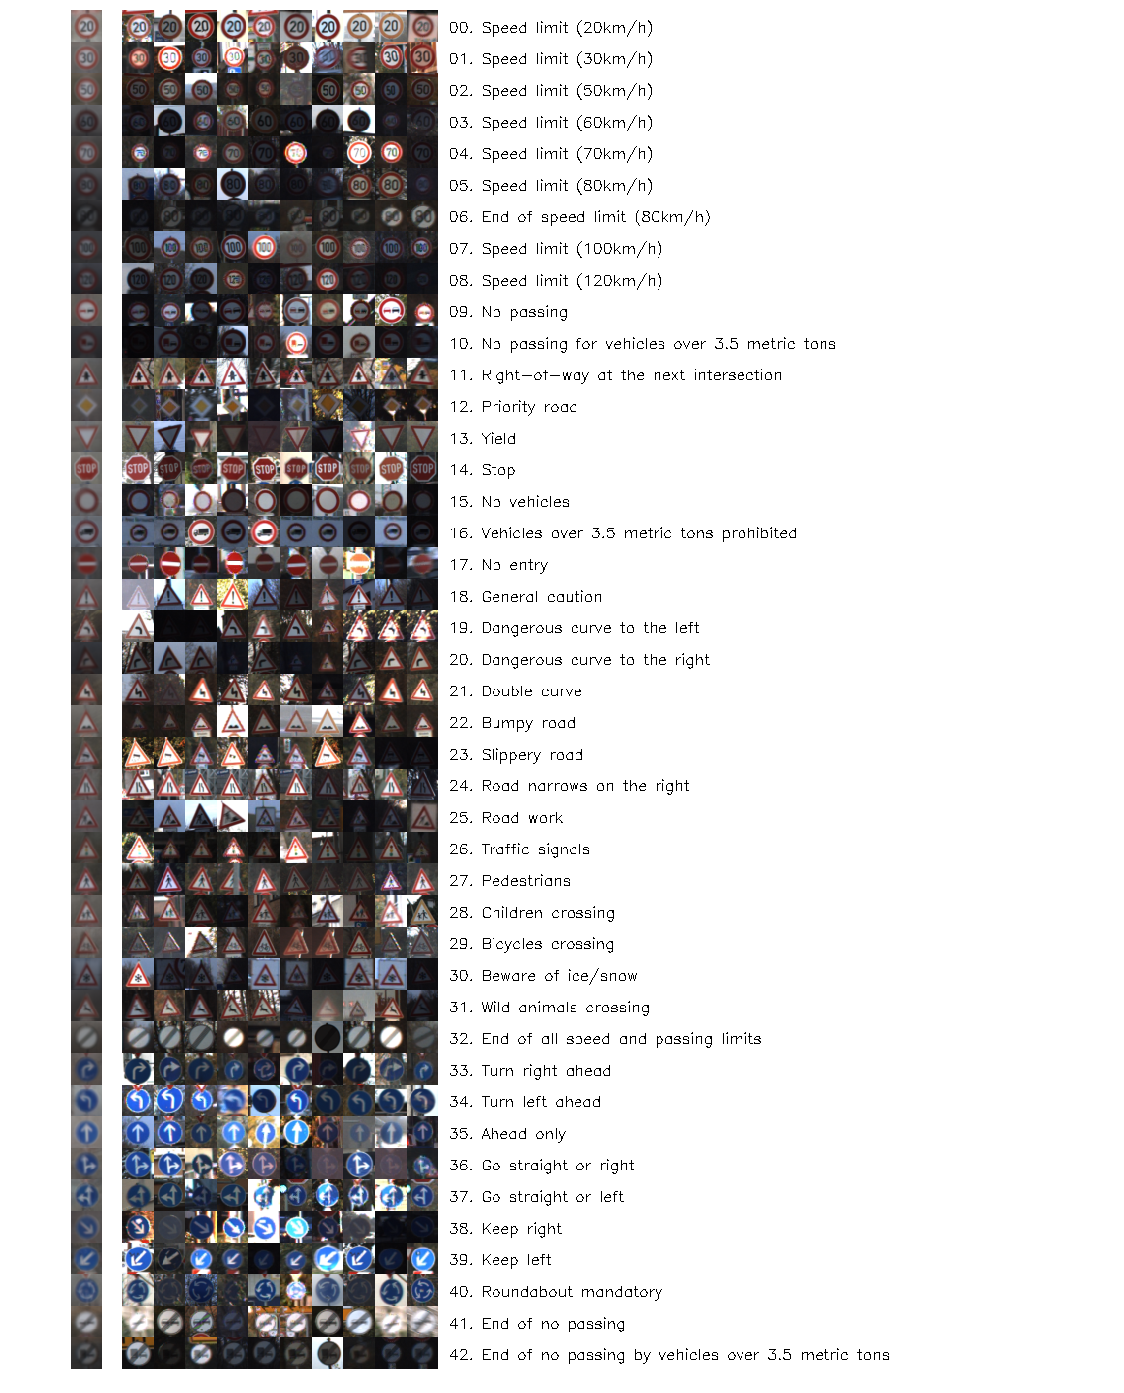

In [6]:
display_image_set(X_train_file, y_train_file)

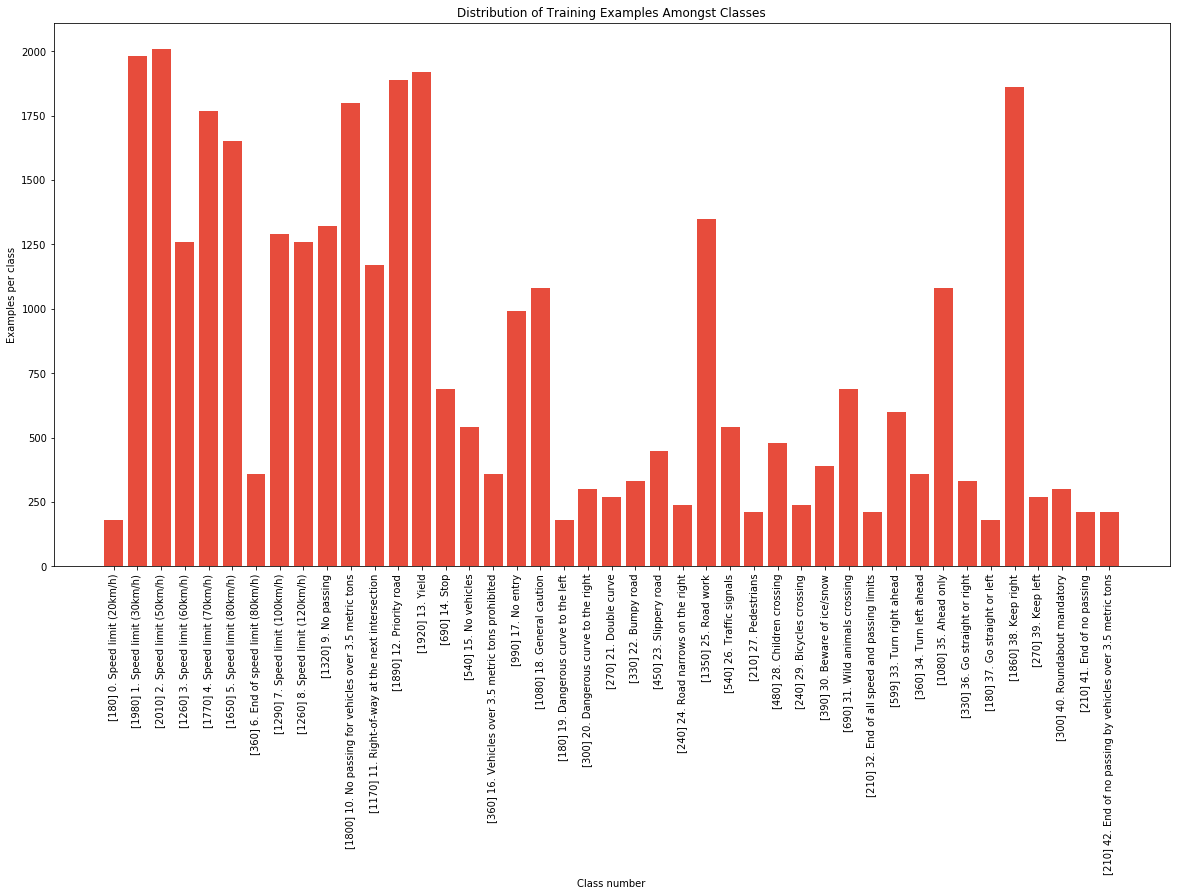

In [62]:
%matplotlib inline
X_train_file_titles = list(map(lambda x: '[{}] {}. {}'.format(len(list(np.where(y_train_file == x[0])[0])), x[0], x[1]), titles))
display_distribution(y_train_file, X_train_file_titles)

---

# 4. Train

---

## 4.1. Train 1 - Initial Set Grayscled Normalized

We begin our training from normalized gray image. This will train our model based on the structure of signs but not their color. Our model can handle only 3 channel images so we need to replace RGB with Gray-Gray-Gray versions. Using cv2 with convert both training and validation sets to Gray and normalize them between 0-255. Then we normalize with a mean by standard deviation with a center at zero.

In [8]:
probe = 0.95
epochs = 5
data_train = (normalize_mean(to_normalized_gray(np.copy(X_train_file))), y_train_file)
data_valid = (normalize_mean(to_normalized_gray(np.copy(X_valid_file))), y_valid_file)

calculate(data_train, data_valid, epochs, probe)

tensorboard --logdir=./logs
http://0.0.0.0:6006/
New session

Start training global_step: 0
Training Loss 22.090; Accuracy 0.965
Validation Loss 51.577; Accuracy 0.873
Model saved to ./model/p2_net-272

Start training global_step: 272
Training Loss 8.973; Accuracy 0.987
Validation Loss 37.379; Accuracy 0.905
Model saved to ./model/p2_net-544

Start training global_step: 544
Training Loss 4.575; Accuracy 0.994
Validation Loss 35.155; Accuracy 0.916
Model saved to ./model/p2_net-816

Start training global_step: 816
Training Loss 2.085; Accuracy 0.998
Validation Loss 31.183; Accuracy 0.924
Model saved to ./model/p2_net-1088

Start training global_step: 1088
Training Loss 1.881; Accuracy 0.998
Validation Loss 31.695; Accuracy 0.932
Model saved to ./model/p2_net-1360



In [9]:
data_test = (normalize_mean(np.copy(X_test_file)), y_test_file)
test_session(data_test)

Start test session ./model/p2_net-1360
Testing Loss 46.223; Accuracy 0.903


---

## 4.2. Train 2 - Initial Set RGB Normalized

We use our initial RGB images with a normalization around zero like we do with grayscale.

In [10]:
probe = 0.95
epochs = 5
data_train = (normalize_mean(np.copy(X_train_file)), y_train_file)
data_valid = (normalize_mean(np.copy(X_valid_file)), y_valid_file)

calculate(data_train, data_valid, epochs, probe)

tensorboard --logdir=./logs
http://0.0.0.0:6006/
Restore session ./model/p2_net-1360

Start training global_step: 1360
Training Loss 2.300; Accuracy 0.996
Validation Loss 35.318; Accuracy 0.923
Model saved to ./model/p2_net-1632

Start training global_step: 1632
Training Loss 1.951; Accuracy 0.996
Validation Loss 37.103; Accuracy 0.921
Model saved to ./model/p2_net-1904

Start training global_step: 1904
Training Loss 0.772; Accuracy 0.999
Validation Loss 28.293; Accuracy 0.936
Model saved to ./model/p2_net-2176

Start training global_step: 2176
Training Loss 2.237; Accuracy 0.996
Validation Loss 32.070; Accuracy 0.933
Model saved to ./model/p2_net-2448

Start training global_step: 2448
Training Loss 1.848; Accuracy 0.996
Validation Loss 33.239; Accuracy 0.925
Model saved to ./model/p2_net-2720



In [11]:
data_test = (normalize_mean(np.copy(X_test_file)), y_test_file)
test_session(data_test)

Start test session ./model/p2_net-2720
Testing Loss 39.084; Accuracy 0.921


---

## 4.3. Train 3 - Augmented Set RGB Normalized

We use our initial RGB and apply transformations and brightness randomization to obtain bigger image set from initial one.
Same normalization applied. We define sets of classes which can have a valid meaning after flipping. Like priority road which you can flip up and down, left and right. But this will be the same priority road sign.

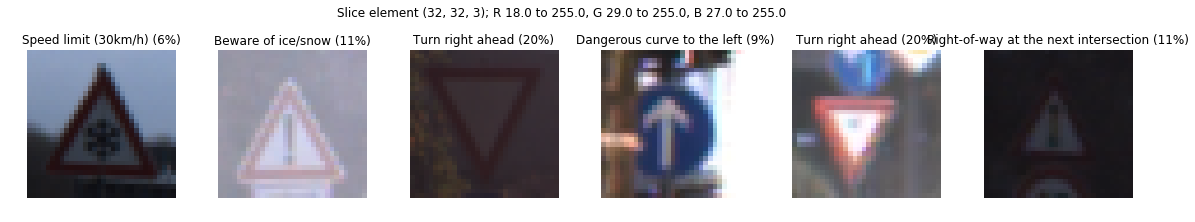

IndexError: list index out of range

In [161]:
flip_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
flip_vertically = np.array([1, 5, 12, 15, 17, 40])
flip_both = np.array([12, 15, 17, 32, 40])
flip_cross = np.array([
    [19, 20],
    [33, 34],
    [36, 37],
    [38, 39],
    [20, 19],
    [34, 33],
    [37, 36],
    [39, 38],
])

X_train_extended = np.empty([0, X_train_file.shape[1], X_train_file.shape[2], X_train_file.shape[3]], dtype = np.uint8)
y_train_extended = np.empty([0], dtype=np.int32)

X_horiz_flip, y_horiz_flip = flip_images(flip_horizontally, X_train_file, y_train_file, 'horizontal')
X_train_extended = np.concatenate((X_train_extended, X_horiz_flip), axis = 0)
y_train_extended = np.concatenate((y_train_extended, y_horiz_flip), axis = 0)
display_image_batch(X_horiz_flip, y_horiz_flip)
X_horiz_flip = None
y_horiz_flip = None

X_vert_flip, y_vert_flip = flip_images(flip_vertically, X_train_file, y_train_file, 'vertical')
X_train_extended = np.concatenate((X_train_extended, X_vert_flip), axis = 0)
y_train_extended = np.concatenate((y_train_extended, y_vert_flip), axis = 0)
display_image_batch(X_vert_flip, y_vert_flip)
X_vert_flip = None
y_vert_flip = None

X_cross_flip, y_cross_flip = cross_flip(flip_cross, X_train_file, y_train_file)
X_train_extended = np.concatenate((X_train_extended, X_cross_flip), axis = 0)
y_train_extended = np.concatenate((y_train_extended, y_cross_flip), axis = 0)
display_image_batch(X_cross_flip, y_cross_flip)
X_cross_flip = None
y_cross_flip = None

X_both_flip, y_both_flip = flip_images(flip_both, X_train_file, y_train_file, 'both')
X_train_extended = np.concatenate((X_train_extended, X_both_flip), axis = 0)
y_train_extended = np.concatenate((y_train_extended, y_both_flip), axis = 0)
display_image_batch(X_both_flip, y_both_flip)
X_both_flip = None
y_both_flip = None

X_train_shuffled, y_train_shuffled = shuffle(X_train_file, y_train_file)
X_train_shuffled, y_train_shuffled = np.array_split(X_train_shuffled, 2)[0], np.array_split(y_train_shuffled, 2)[0]

for i in range(len(X_train_shuffled)):
    X_train_shuffled[i] = augment(X_train_shuffled[i], 0.8, 10, 4, 3)
    
X_train_extended = np.concatenate((X_train_extended, X_train_shuffled), axis = 0)
y_train_extended = np.concatenate((y_train_extended, y_train_shuffled), axis = 0)

print("Extended examples:", X_train_extended.shape)
display_distribution(y_train_extended, titles, height = 3)

In [18]:
probe = 0.95
epochs = 5
data_train = (normalize_mean(np.copy(X_train_extended)), y_train_extended)
data_valid = (normalize_mean(np.copy(X_valid_file)), y_valid_file)

calculate(data_train, data_valid, epochs, probe)

tensorboard --logdir=./logs
http://0.0.0.0:6006/
Restore session ./model/p2_net-2720

Start training global_step: 2720
Training Loss 53.660; Accuracy 0.876
Validation Loss 44.689; Accuracy 0.891
Model saved to ./model/p2_net-3054

Start training global_step: 3054
Training Loss 27.757; Accuracy 0.938
Validation Loss 33.500; Accuracy 0.921
Model saved to ./model/p2_net-3388

Start training global_step: 3388
Training Loss 20.206; Accuracy 0.953
Validation Loss 38.601; Accuracy 0.903
Model saved to ./model/p2_net-3722

Start training global_step: 3722
Training Loss 13.456; Accuracy 0.971
Validation Loss 36.641; Accuracy 0.914
Model saved to ./model/p2_net-4056

Start training global_step: 4056
Training Loss 9.818; Accuracy 0.980
Validation Loss 39.948; Accuracy 0.913
Model saved to ./model/p2_net-4390



In [19]:
data_test = (normalize_mean(np.copy(X_test_file)), y_test_file)
test_session(data_test)

Start test session ./model/p2_net-4390
Testing Loss 38.849; Accuracy 0.915


---

# 5. Testing on Images From Web

---

Let's use a bunch of images downloaded from web. We will try with images from a test set first, then on downloaded data.

In [ ]:
validation_set = X_valid_file, y_valid_file
examples_session(X_test_file[:10], validation_set, classes, labels=y_test_file[:10], height=15)

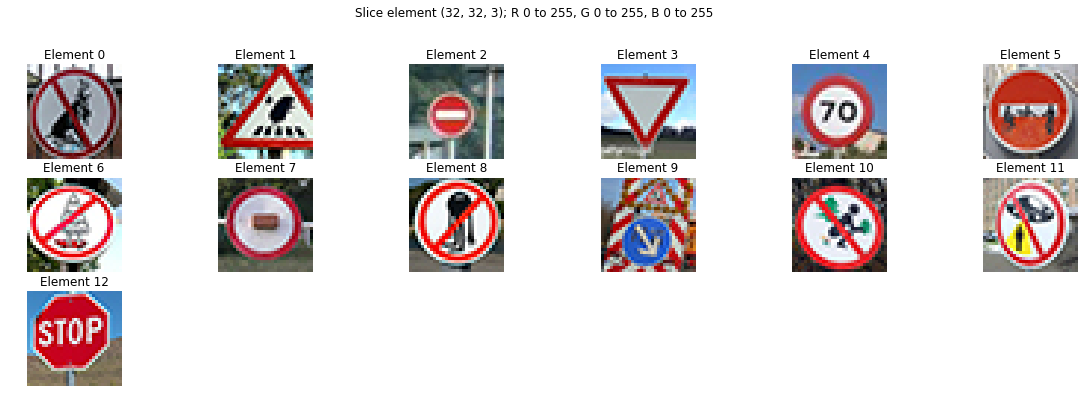

In [147]:
import os
import matplotlib.image as mpimg

X_examples = np.empty([0, 32, 32, 3], dtype = np.uint8)

for file in os.listdir('./examples'):
    if '.jpg' in file:
        X_examples = np.concatenate((X_examples, mpimg.imread('./examples/' + file)[None,:]), axis=0)

display_images(X_examples, 6, height=8)

Start examples session ./model/p2_net-4390


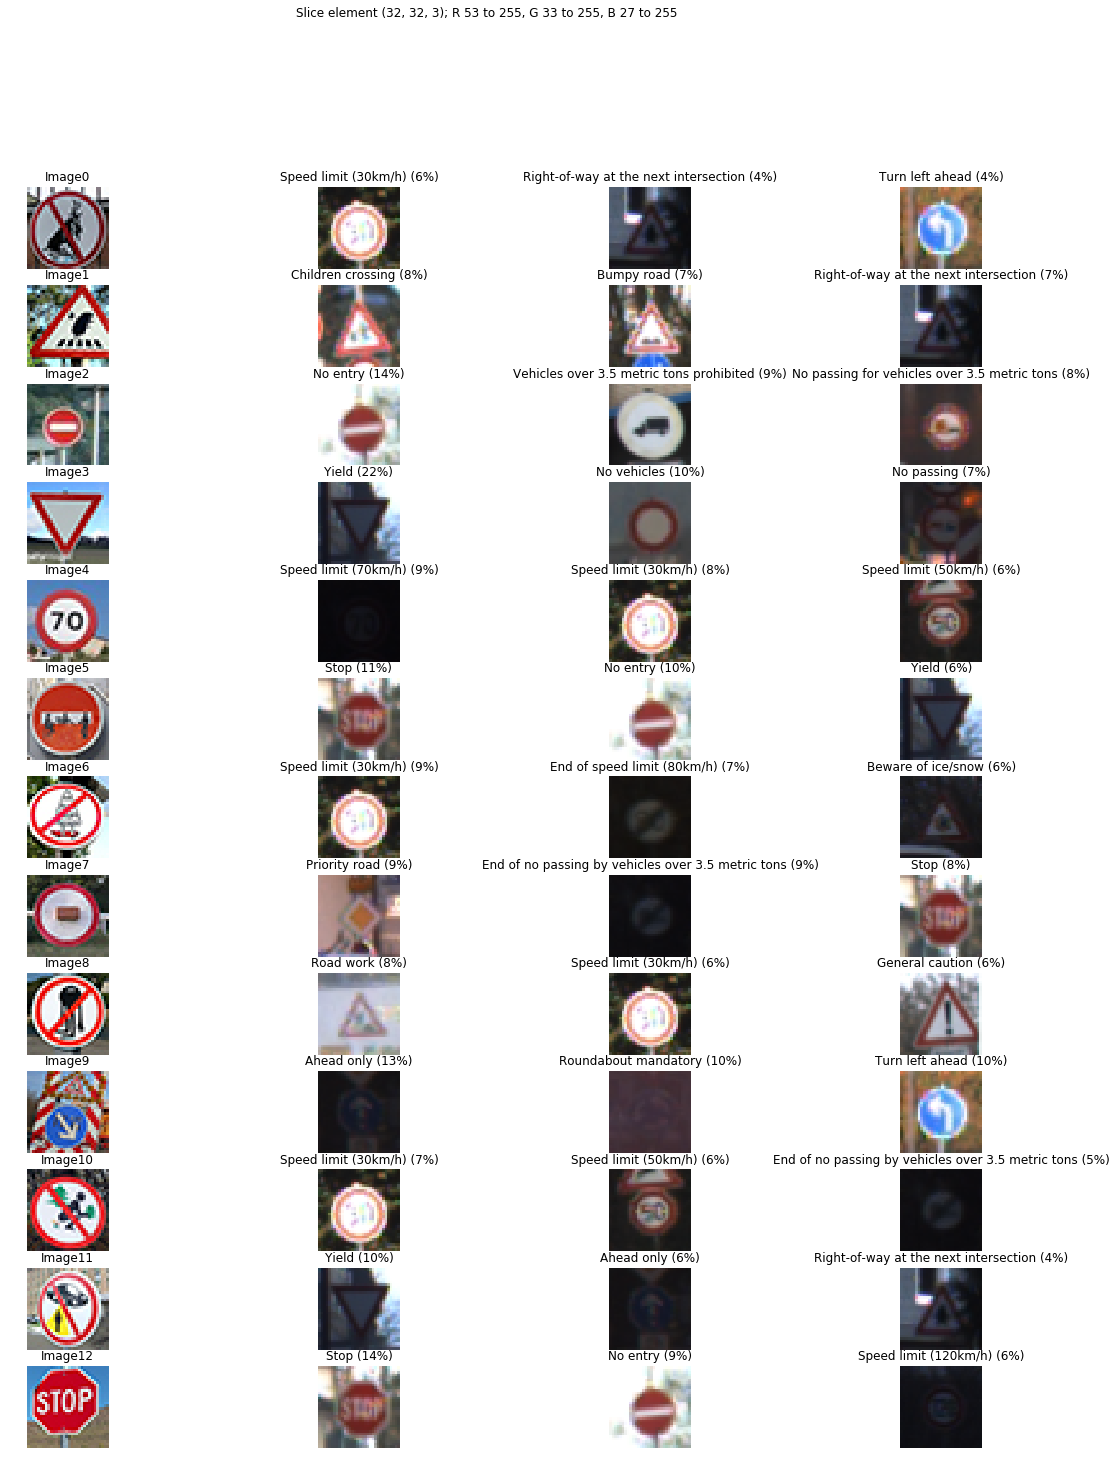

In [159]:
validation_set = X_valid_file, y_valid_file
examples_session(X_examples, validation_set, classes, height=25)

---

# ACTIVATION AND WEIGHTS MAPS ARE PLOTTED TO TENSORBOARD. SEE ABOVE



## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")